In [13]:
import torch
import torch.utils.data.dataloader
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import pcs.models.pointconv
import pcs.dataset

In [2]:
BATCH_SIZE = 100
NUM_CLASSES = 8

In [3]:
# TODO: more transforms, normalization, etc.
# TODO: aggregate more neighborhoods
# TODO: data augmentation
# TODO: stratification
dataset = pcs.dataset.SemSegDataset(
    data_dir="./data/aggregated/bild/",
    point_transforms=(lambda x: torch.tensor(x.T, dtype=torch.float32), ),
    label_transforms=(
        lambda x: np.array(x - 1, dtype=int),
        lambda x: torch.eye(NUM_CLASSES)[x],
    )
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [4]:
EPOCH_LENGTH = len(dataset) // BATCH_SIZE + bool(len(dataset) % BATCH_SIZE)

In [5]:
model = pcs.models.pointconv.PointConvNet(features=4, classes=NUM_CLASSES)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
model.train()

PointConvNet(
  (sa1): FeatureEncoder(
    (mlp_convs): ModuleList(
      (0): Conv2d(7, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (weightnet): WeightNet(
      (mlp_convs): ModuleList(
        (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0-1): 2 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (linear): Linear(in_features=1024,

In [7]:
def train_one_epoch() -> float:
    loss_agg = []
    pbar = tqdm.tqdm(dataloader, total=EPOCH_LENGTH)
    for data, labels in pbar:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.item())
        pbar.set_description(f"Loss: {loss.item()}")
    mean_loss = np.array(loss_agg).mean()
    print(f"Mean loss: {mean_loss}")
    return mean_loss

losses = []
# Note: PoC, only 10 epochs
# Training takes long time nonetheless
for epoch in range(10):
    print(f"Epoch {epoch}")
    epoch_loss = train_one_epoch()
    losses.append(epoch_loss)

Epoch 0


  0%|          | 0/21 [00:00<?, ?it/s]

Loss: 33.30084228515625: 100%|██████████| 21/21 [12:06<00:00, 34.60s/it] 


Mean loss: 33.30606587727865
Epoch 1


Loss: 33.28226852416992: 100%|██████████| 21/21 [12:19<00:00, 35.21s/it] 


Mean loss: 33.2845215570359
Epoch 2


Loss: 33.2812614440918: 100%|██████████| 21/21 [12:28<00:00, 35.63s/it]  


Mean loss: 33.291605086553666
Epoch 3


Loss: 33.28646469116211: 100%|██████████| 21/21 [12:23<00:00, 35.41s/it] 


Mean loss: 33.28911318097796
Epoch 4


Loss: 33.28071975708008: 100%|██████████| 21/21 [11:59<00:00, 34.25s/it] 


Mean loss: 33.286648341587615
Epoch 5


Loss: 33.280399322509766: 100%|██████████| 21/21 [12:03<00:00, 34.46s/it]


Mean loss: 33.2855951218378
Epoch 6


Loss: 33.27577590942383: 100%|██████████| 21/21 [12:05<00:00, 34.52s/it] 


Mean loss: 33.28185744512649
Epoch 7


Loss: 33.275577545166016: 100%|██████████| 21/21 [11:58<00:00, 34.23s/it]


Mean loss: 33.28069214593796
Epoch 8


Loss: 33.27995681762695: 100%|██████████| 21/21 [12:09<00:00, 34.72s/it] 


Mean loss: 33.27996263049898
Epoch 9


Loss: 33.375247955322266: 100%|██████████| 21/21 [12:09<00:00, 34.73s/it]

Mean loss: 33.2977176847912


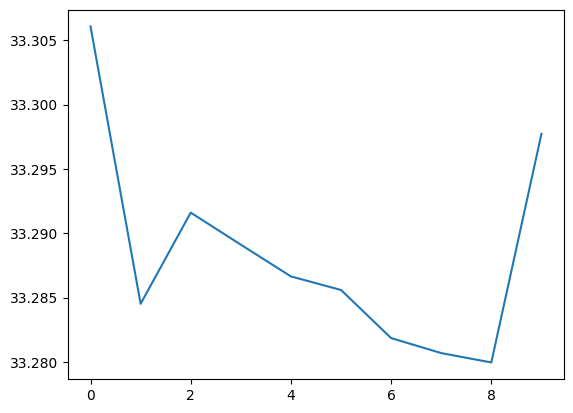

In [14]:
# TODO: verify correctness
plt.plot(losses)